# Визуализация

В модуле собраны скрипты для визуализации данных. В основном они полезны для анализа задачи бинарной классификации.

Для начала сгенерируем игрушечный пример.

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

np.random.seed(42)

N=10000

X, y = make_classification(n_features=4, n_samples=N)

df = pd.DataFrame(X, columns=['feature_%d' % i for i in range(X.shape[1])])
df['y'] = y
df['sample_date'] = np.random.choice(pd.date_range('2025-01-01', '2025-12-31'), N)
df['category_feature'] = np.random.choice(['foo', 'bar', np.nan], N)

df.head(2)

,feature_0,feature_1,feature_2,feature_3,y,sample_date,category_feature
0,1.522650,-0.934560,-0.465022,0.058874,0,2025-09-20,bar
1,1.048103,-0.746806,0.436853,0.859628,1,2025-07-15,nan


В игрушечной выборке содержатся:

*  несколько признаков `feature_*`
*  бинарная целевая переменная - `y`
*  поле с датой - `sample_date`
*  категорияльное поле `category_feature`

Для работы скриптов потребуется пакет [holoviews](http://holoviews.org). Большинство скриптов - функции, возвращающие одну картинку, а точнее [Overlay](http://holoviews.org/reference/containers/bokeh/Overlay.html) с различными точками, линимями, ...  

In [2]:
import holoviews as hv
hv.extension('matplotlib')

/Users/dmitriy/anaconda3/lib/python3.6/site-packages/holoviews/plotting/mpl/__init__.py:30: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


Проилюстируем работу некоторых функций

In [3]:
from risksutils.visualization import woe_line, woe_stab, cross_tab, isotonic, distribution

### woe_line

:Overlay
   .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
   .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
   .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
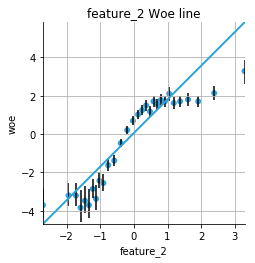

In [4]:
woe_line(df=df, feature='feature_2', target='y', num_buck=30)

Данная функция разбивает числовой признак `feature` на `num_buck` бакетов. И в каждом бакете считается <br>
$\text{Weight of Evidence} = \ln\left(\frac{\text{доля 1 в бакте}}{\text{доля 0 в бакете}}\right)
- \ln\left(\frac{\text{доля 1 во всей выборке}}{\text{доля 0 во всей выборке}}\right)$.  

Если в бакете доля объектов класса 1 совпадает с долей 1 во всей выборке, то $WoE = 0$. Если в бакете присутствуют только объекты одного класса, то WoE будет равно бесконечности – из-за взятия логарифма. В данной функции доля объектов каждого класса ограничивается 0.001 - снизу и 0.999 - сверху.

На самом графике [woe_line](#woe_line) показана зависимость WoE в бакете от среднего значения признака `feature` в нем. 

На примере графика выше можно сказать, что среди объектов со значением feature_2 > 1 гораздо чаще присутствует 1.

### isotonic

:Overlay
   .Isotonic.I            :Curve   [predict]   (isotonic)
   .Confident_Intervals.I :Area   [predict]   (ci_l,ci_h)
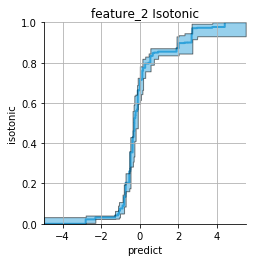

In [5]:
isotonic(df=df, predict='feature_2', target='y')

График [isotonic](#isotonic) похож на график [woe_line](#woe_line) - так же отображается зависимость частоты объектов класса 1 от значений признака, только явная разбивка на бакеты отсутствует. Построение зависимости основано на [Isotonic Regression](http://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html), которая восстанавливает монотонную зависимость. 

Использовать [isotonic](#isotonic) совместно с доверительными интервалами удобно для проверки совпадения прогноза с фактическими данными. Так, как обычно, предполагается монотонное влияние прогноза на целевую переменную.

### distribution

:NdOverlay   [bucket]
   :Spread   [sample_date]   (objects_rate,obj_rate_l,obj_rate_u)
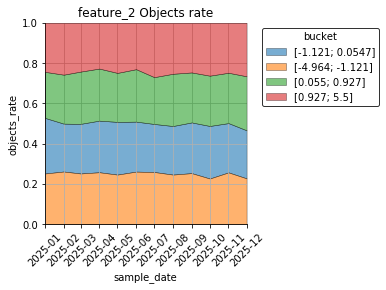

In [6]:
distribution(df=df, feature='feature_2', date='sample_date', num_buck=4)

Данная диаграмма отражает изменение распределений признака `feature` во времени `date`. Признак дискретезируется разбивкой на бакеты. Затем выборка разбивается на группы (по умолчанию на месяца – параметр `date_freq`), и в каждой группе считается доля объектов из каждого бакета. По данному графику [distribution](#distribution) удобно обнаруживать изменения в расчете признака во времени.

### woe_stab

:Overlay
   .Confident_Intervals.I :NdOverlay   [bucket]
      :Spread   [sample_date]   (woe,woe_b,woe_u)
   .Weight_of_evidence.I  :NdOverlay   [bucket]
      :Curve   [sample_date]   (woe)
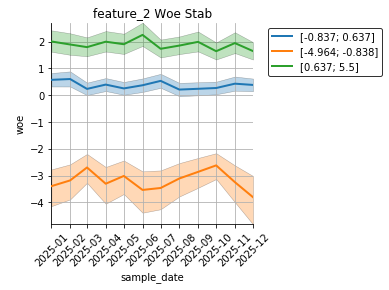

In [7]:
woe_stab(df=df, feature='feature_2', target='y', date='sample_date', num_buck=3)

На данном графике отображается изменение влияния признака `feature` на целевую переменную `target` во времени `date`. Для этого признак разбивается на бакеты и для каждой временной группы считаются значения WoE.

В данном игрушечном примере видно, что влияние `feature_2` на `y` стабильно по времени. Это и должно быть, так как мы сгенерировали поле `sample_date` случайно и независимо от остальной выборки.

### cross_tab

In [8]:
cross_tab(df, 'feature_2', 'category_feature', 'y', num_buck1=3, num_buck2=3)

category_feature,bar,foo,nan,All
feature_2,,,,
[-4.964; -0.838],3.97%,4.49%,4.06%,4.17%
[-0.837; 0.637],59.96%,59.53%,57.92%,59.14%
[0.637; 5.5],86.80%,87.02%,86.18%,86.68%
All,50.16%,51.13%,48.67%,50.00%
category_feature,bar,foo,nan,All
feature_2,,,,
[-4.964; -0.838],1134,1091,1108,3333
[-0.837; 0.637],1099,1117,1117,3333
[0.637; 5.5],1136,1156,1042,3334


Данный скрипт отличается тем, что возвращает не объект [holoviews](http://holoviews.org), а набор [pandas.dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), а точнее набор [Styler](https://pandas.pydata.org/pandas-docs/stable/style.html) - dataframe c визуальными настройками. 

В [cross_tab](#cross_tab) визуализируется совместное влияние пары признаков на целевую переменную (аналогично [pandas.crosstab](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html)). Каждый признак разбивается на бакеты и считается доля объектов класса 1 в каждой комбинации пары бакетов - первая таблица. А так же считается общее количество объектов - вторая таблица. Вместе с этим выводятся агрегированные статистики - последние строка и столбец.

## Настройка графиков

Для придания графикам различных свойств используются [насторойки holoview](http://holoviews.org/user_guide/Customizing_Plots.html). Каждый тип графика состоит из набора базовых диаграмм, например, [woe_line](#woe_line) - это наложенные ([Overlay](http://holoviews.org/reference/containers/matplotlib/Overlay.html#matplotlib-gallery-overlay)) друг на друга диаграммы:
* Диаграмма рассеивания ([Scatter](http://holoviews.org/reference/elements/matplotlib/Scatter.html#matplotlib-gallery-scatter)) со значениями WoE;
* Диаграмма ошибок ([ErrorBars](http://holoviews.org/reference/elements/matplotlib/ErrorBars.html#matplotlib-gallery-errorbars)) со значениями доверительный интервалов для WoE;
* Линия ([Curve](http://holoviews.org/reference/elements/matplotlib/Curve.html#matplotlib-gallery-curve)) с реультатом зависимости целевой переменной от признака из [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Для того, чтобы вывести структуру диаграммы нужно вызвать `print` от неё.

In [9]:
diagram = woe_line(df=df, feature='feature_2', target='y', num_buck=30)
print(diagram)

:Overlay
   .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
   .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
   .Logistic_interpolations.I :Curve   [feature_2]   (logreg)


В выводе присутствуют в дополнение пользовательские названия диаграмм, например, "Confident_Intervals" для ErrorBars, а так же названия осей.

Для настройки графиков можно воспользоваться магической командой `%%opts`.

:Overlay
   .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
   .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
   .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
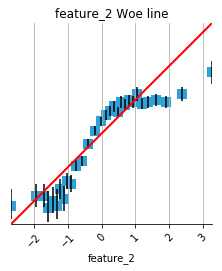

In [10]:
%%opts Curve [xrotation=45 yaxis=None] (color='red') Scatter (marker='s' s=100)
diagram

Синтаксис команды следующий: `%%opts  Diagram [plotting options] (style options) {normalization}`.
* `plotting options` (те, что в квадратных скобках) отвечают за функцианальное наполнение графиков, например, опцией `xrotation=45` мы повернули подписи у оси x на 45 градусов, а за счет `yaxis=None` убрали ось y. Заметим, что эти настройки были применены к типу Curve, но повлияли на всю диаграмму.
* `style options` (в круглых скобках) изменяют визуальное оформление диаграмм. С помощью `color='red'` поменялся цвет у Curve, а с помощью `marker='s' s=100` мы сделали у Scatter маркеры в виде квадратов (squere) и размера 100.
* `normalization` (в фигурных скобках) отвечает за связь разных диаграмм между собой. Далее мы рассмотрим пример.

В jupyter notebook-ах для настроек работает автодополнение, например:
* `%%opts C<TAB>` выдаст подсказки `Collator`, `Contours`, `Curve`;
* `%%opts Curve [xaxis=None sh<TAB>` выдает `show_frame=`, `show_grid=`, ... .

Для более подробного описания настроек можно вызвать справку, например, `hv.help(hv.Overlay)`, а так же посмотреть примеры из документации.

Помимо настройки `%%opts` (с двумя процентами) так же есть и настройка `%opts` с одним они различаются следущим:
* `%%opts` - локальные настройки, применяются ко всем диаграммам, созданным в данной ячейке;
* `%opts` - глобальные настройки, применяется **ко всем диагрммам в ноутбуке**.

:Layout
   .Woe_line.Feature_2 :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
   .Curve.I            :Curve   [x]   (y)
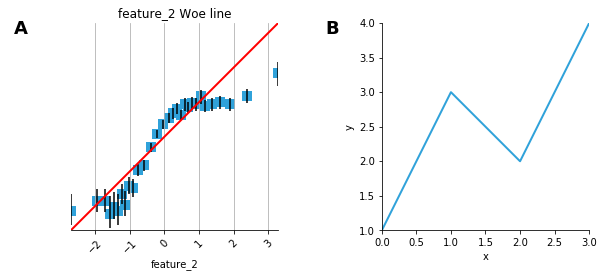

In [11]:
simple_curve = hv.Curve([1, 3, 2, 4])
diagram + simple_curve

В примере выше я вывел вместе две диаграммы: `diagram` и созданную `Curve`, при этом настройки у `diagram` сохранились, так как мы их применили ячейкой выше, а у новой диаграммы они остались прежними. Если мы теперь захотим поменять настройки только у одной кривой из двух, можно воспользоваться её именем.

In [12]:
print(diagram + simple_curve)

:Layout
   .Woe_line.Feature_2 :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
   .Curve.I            :Curve   [x]   (y)


:Layout
   .Woe_line.Feature_2 :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
   .Curve.I            :Curve   [x]   (y)
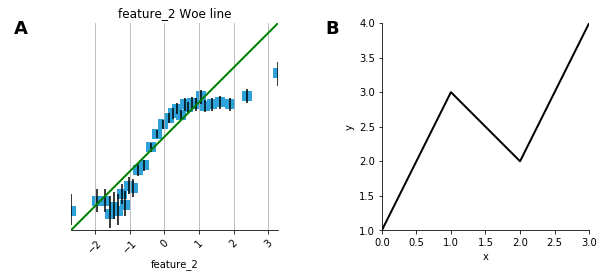

In [13]:
%%opts Curve.Logistic_interpolations (color='green') Curve (color='black')
diagram + simple_curve

Помимо настроек `%%opts` так же доступны настройки `%%output`, позволяющие менять размер и вывод

:Overlay
   .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
   .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
   .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
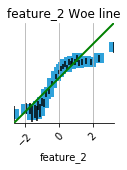

In [14]:
%%output size=50
diagram

Из полезных настроек: c помощью `%%output filename=` можно сохранить картинку в файл.

## Backend

В самом начале мы подключали backend matplotlib с помощью `hv.extension('matplotlib')`, но нам так же доступен и другой backend -  [`bokeh`](https://bokeh.pydata.org/en/latest).


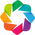

In [15]:
hv.extension('bokeh')

In [16]:
isotonic(df=df, predict='feature_2', target='y')

:Overlay
   .Isotonic.I            :Curve   [predict]   (isotonic)
   .Confident_Intervals.I :Area   [predict]   (ci_l,ci_h)

В нем появляется возможность делать интерактивные диаграммы.

## Совмещение диаграмм

Для визуализации данных бывает полезно выводить не по одной диаграмме а сразу несколько, и holoviews позволяет это сделать очень удобно.

Над диаграммами переопределены арифметические операции:
* **`+`** - [`Layout`](http://holoviews.org/reference/containers/matplotlib/Layout.html) рисует диаграммы рядом друг с другом;
* **`*`** - [`Overlay`](http://holoviews.org/reference/containers/matplotlib/Overlay.html) накладывает диаграммы друг на друга.

In [17]:
wl_2 = woe_line(df=df, feature='feature_2', target='y', num_buck=30)
ws_2 = woe_stab(df=df, feature='feature_2', target='y', date='sample_date', num_buck=3)

wl_2 + ws_2

:Layout
   .Woe_line.Feature_2 :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
   .Woe_Stab.Feature_2 :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)

При рисовании диаграмм рядом друг с другом происходит совмещение осей (если они называются одинаково). Чтобы этого не происходило можно воспольоваться настройками normalization (те, что в фигурных скобках) - если добавить `%%opts Spread {+axiswise}`, то сцепление первого типа диаграммы Spread из второго графика `ws_2` пропадет.

Также есть удобная возможность рисовать сразу несколько диаграмм напрямую через конструктор `hv.Layout`.

In [18]:
hv.extension('matplotlib')

:Layout
   .Woe_Stab.Feature_0        :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)
   .Woe_Stab.Feature_1        :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)
   .Woe_Stab.Feature_2        :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)
   .Woe_Stab.Feature_3        :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)
   .Woe_Stab.Category_feature :Overlay
      .Confident_Intervals.I :NdOverlay   [bucket]
         :Spread   [sample_date]   (woe,woe_b,woe_u)
      .Weight_of_evidence.I  :NdOverlay   [bucket]
         :Curve   [sample_date]   (woe)
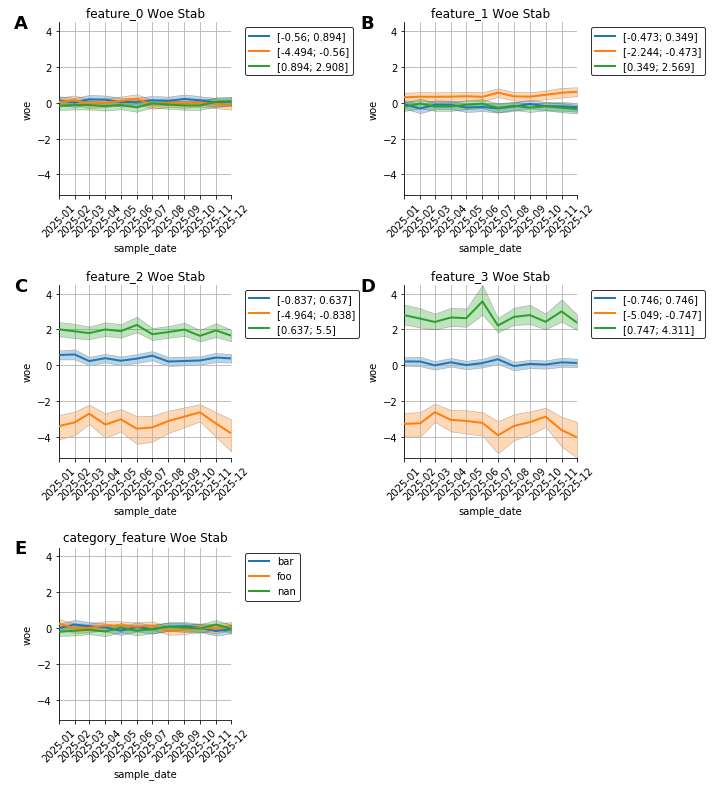

In [19]:
%%opts Layout [hspace=1 vspace=0.5]

features = ['feature_' + str(i) for i in range(4)] + ['category_feature']
hv.Layout([woe_stab(df, f, 'y', 'sample_date', num_buck=3) for f in features]).cols(2)

Внутри hv.Layout мы создали лист с четыремя диаграммами, а вызвав метод `cols(2)` нарисовали все в 2 колонки.  
Настройка `hspace=1` позволяет сделать отступы между графиками, расположенными горизонтально друг от друга для того, чтобы уместились легенды, а `vspace=0.5` - между вертикально расположенными графиками.

## Интерактивность

Один из мощных инструментом в holoviews - это создание интерактивных графиков, позволящих с помощью виджетов перебирать различные диаграммы. Доступно два базовых типа:
* [`HoloMap`](http://holoviews.org/reference/containers/matplotlib/HoloMap.html#matplotlib-gallery-holomap) - из словаря с ключем - название диаграммы, а значением сомами диаграммами создается интервактивный график (пример ниже).
* [`DynamicMap`](http://holoviews.org/reference/containers/matplotlib/DynamicMap.html#matplotlib-gallery-dynamicmap) - динамичная диаграммы, вычисляющая по положениям виджетов встроенную диаграмму. Для DynamicMap нужно задать функцию, которая это сделает и вычислению будут происходить только при запущенной сессии Python (за то не тратится место на хранение сразу всех диаграмм как у `HoloMap`).

:HoloMap   [buckets]
   :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_2]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_2]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_2]   (logreg)
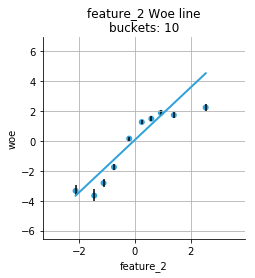
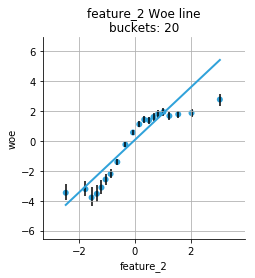
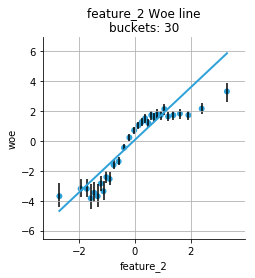
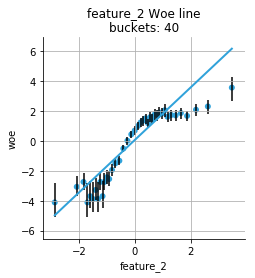
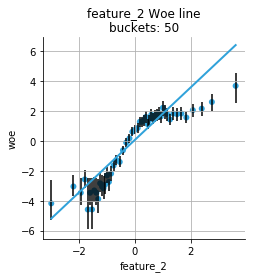
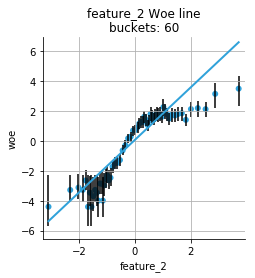
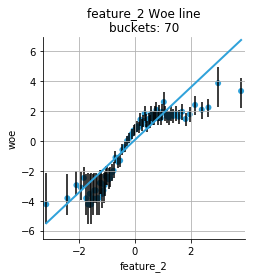
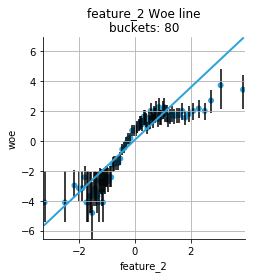
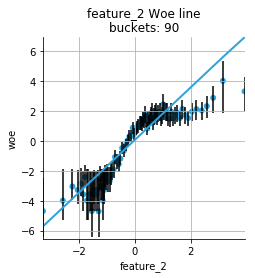

In [20]:
hv.HoloMap({i: woe_line(df, 'feature_2', 'y', num_buck=i) for i in range(10, 100, 10)}, kdims=['buckets'])

В данном примере мы внутри `hv.Holomap` создали словарь с ключем `i` и значением - диаграммой woe_line, с разбивкой признака `feature_2` как раз на `i` бакетов. Теперь с помощью виджета можно посмотреть как меняется график при изменении количества бакетов. Видно, что график становится подробнее, вместе с тем растут доверительные интервалы у оцененных значений woe.  

Можно так же создавать сразу несколько виджетов, если ключ будет более сложным объектом tuple (в случае ниже пара - название признака и количество бакетов).

:HoloMap   [feature,buckets]
   :Overlay
      .Weight_of_evidence.I      :Scatter   [feature_3]   (woe)
      .Confident_Intervals.I     :ErrorBars   [feature_3]   (woe,woe_u,woe_b)
      .Logistic_interpolations.I :Curve   [feature_3]   (logreg)
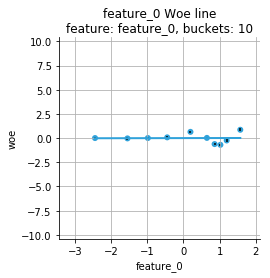
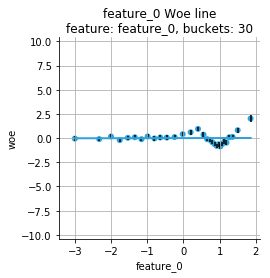
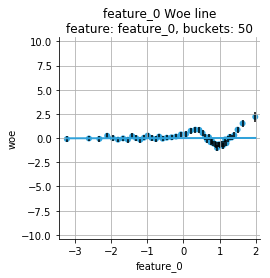
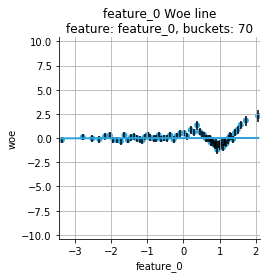
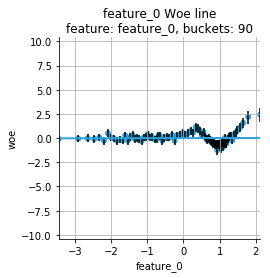
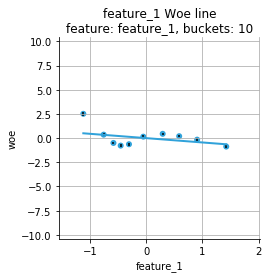
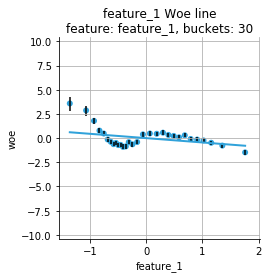
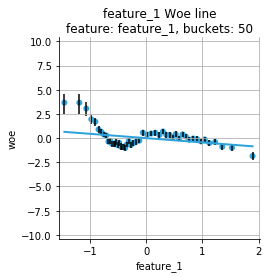
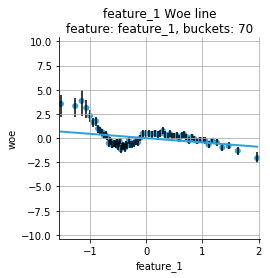
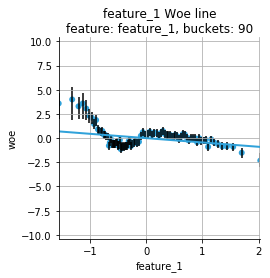
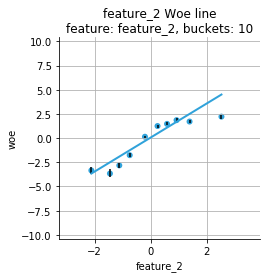
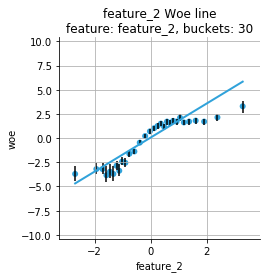
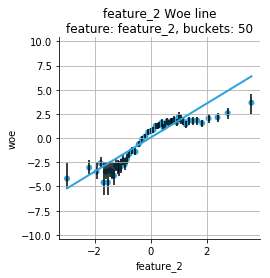
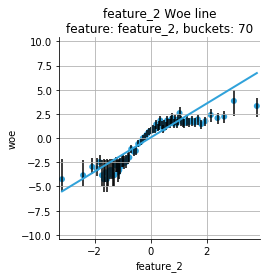
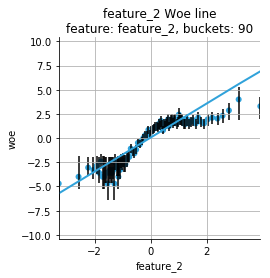
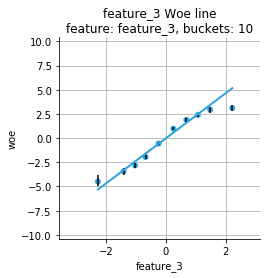
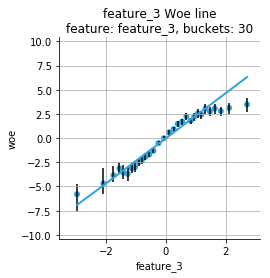
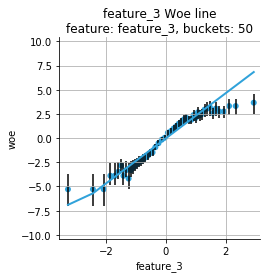
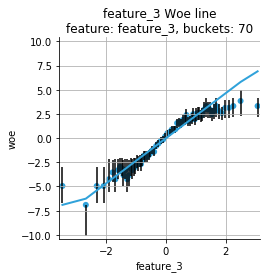
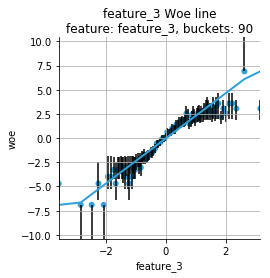

In [21]:
hv.HoloMap({(f, i): woe_line(df, f, 'y', num_buck=i)
            for f in ['feature_' + str(i) for i in range(4)]
            for i in range(10, 100, 20)}, kdims=['feature', 'buckets'])

## Другие возможности

С другими интересными возможностями работы диаграмм стоит обращаться к документации [holoviews](http://holoviews.org).